In [9]:
from typing import Literal

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin, RegressorMixin

In [10]:
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return ((y_pred - y_true) ** 2).mean()

def accuracy(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return np.sum(y_true == y_pred) / y_true.shape[0]

def train_test_split(X: np.ndarray, y: np.ndarray, train: float = .8, seed: int = 42) -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    size = X.shape[0]
    np.random.seed(seed)
    mask = np.random.choice([0, 1], size=size, p=(1 - train, train))
    return X[mask], y[mask], X[~mask], y[~mask]

# Gradient Boosting

## Implementation

In [3]:
class MyDecisionTree(RegressorMixin, BaseEstimator):
    def __init__(self, max_depth: int = 3, min_samples_split: int = 2, criterion: Literal["mse"] = "mse"):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.const: float | None = None

    def fit(self, X: np.ndarray, y: np.ndarray):
        if self.max_depth <= 0 or X.shape[0] < self.min_samples_split:
            self.const = float(np.mean(y))
            return self

        best_score = float("inf")
        best_feature: int | None = None
        best_threshold: float | None = None
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                y_left, y_right = y[left_mask], y[right_mask]

                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                if self.criterion == "mse":
                    score = (np.var(y_left) * len(y_left) + np.var(y_right) * len(y_right)) / len(y)
                else:
                    raise NotImplementedError()

                if score < best_score:
                    best_score = score
                    best_feature = feature
                    best_threshold = threshold

        if best_score == float("inf") or best_feature is None or best_threshold is None:
            self.const = float(np.mean(y))
            return self
        
        self.feature = best_feature
        self.threshold = best_threshold

        left_mask = X[:, self.feature] <= self.threshold
        right_mask = ~left_mask
        self.left = MyDecisionTree(max_depth=self.max_depth - 1, min_samples_split=self.min_samples_split, criterion=self.criterion)\
            .fit(X[left_mask], y[left_mask])
        self.right = MyDecisionTree(max_depth=self.max_depth - 1, min_samples_split=self.min_samples_split, criterion=self.criterion)\
            .fit(X[right_mask], y[right_mask])

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        if self.const is not None:
            return np.full(X.shape[0], self.const)

        left_mask = X[:, self.feature] <= self.threshold
        right_mask = ~left_mask

        y = np.empty(X.shape[0])
        y[left_mask] = self.left.predict(X[left_mask])
        y[right_mask] = self.right.predict(X[right_mask])
        return y

In [2]:
class MyGradientBoosting(RegressorMixin, BaseEstimator):
    def __init__(self, n_estimators: int = 100, learning_rate: float = 0.1, max_depth: int = 3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        self.y0 = np.mean(y)

        delta = y - self.y0
        for _ in range(self.n_estimators):
            tree = MyDecisionTree(max_depth=self.max_depth).fit(X, delta)
            self.trees.append(tree)
            delta -= self.learning_rate * tree.predict(X)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        y = np.full(X.shape[0], self.y0)
        for tree in self.trees:
            y += self.learning_rate * tree.predict(X)
        return y

## Comparison

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

My  mse(0.0008691893628998637)
Lib mse(0.0008691893628998647)


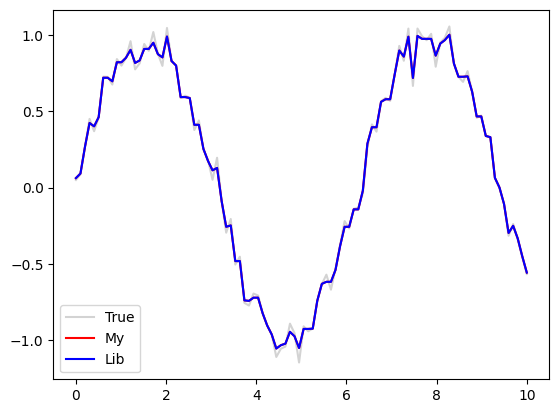

In [17]:
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, size=X.shape[0])

my_y =  MyGradientBoosting(       n_estimators=100, learning_rate=0.1, max_depth=3).fit(X, y).predict(X)
lib_y = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3).fit(X, y).predict(X)

print(f"My  mse({mse(y, my_y)})")
print(f"Lib mse({mse(y, lib_y)})")

plt.plot(X, y, label="True", color="lightgray")
plt.plot(X, my_y, label=f"My", color="red")
plt.plot(X, lib_y, label=f"Lib", color="blue")
plt.legend()

## Testing

In [56]:
df = pd.read_csv("../ml/realestate.txt", sep='\t')

X = df.drop(["SalePrice"], axis=1).to_numpy()
y = df["SalePrice"].to_numpy()

X_train, y_train, X_test, y_test = train_test_split(X, y)

df

,SalePrice,SqFeet,Beds,Baths,Air,Garage,Pool,Year,Quality,Style,Lot,Highway
0,360.0,3.032,4,4,1,2,0,1972,2,1,22.221,0
1,340.0,2.058,4,2,1,2,0,1976,2,1,22.912,0
2,250.0,1.780,4,3,1,2,0,1980,2,1,21.345,0
3,205.5,1.638,4,2,1,2,0,1963,2,1,17.342,0
4,275.5,2.196,4,3,1,2,0,1968,2,7,21.786,0
...,...,...,...,...,...,...,...,...,...,...,...,...
516,137.0,1.655,2,1,0,1,0,1935,3,1,54.651,0
517,185.0,1.944,3,2,1,2,0,1939,3,6,17.999,0
518,133.5,1.922,3,1,0,2,0,1950,3,1,14.805,0
519,124.0,1.480,3,2,1,2,0,1953,3,1,28.351,0


In [60]:
my_score =  mse(y_test, MyGradientBoosting(       n_estimators=100, learning_rate=0.1, max_depth=3).fit(X_train, y_train).predict(X_test))
lib_score = mse(y_test, GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3).fit(X_train, y_train).predict(X_test))

print(f"My  mse({my_score})")
print(f"Lib mse({lib_score})")

My  mse(49452.19566129521)
Lib mse(52769.89153023143)


# AdaBoost

## Implementation

In [11]:
class MyDecisionStump(ClassifierMixin, BaseEstimator):
    def __init__(self, feature: int, threshold: float, polarity: Literal[-1, 1]):
        self.feature = feature
        self.threshold = threshold
        self.polarity = polarity
        self.weight: float = 1

    def predict(self, X: np.ndarray) -> np.ndarray:
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        
        if self.polarity == 1:
            predictions[X[:, self.feature] < self.threshold] = -1
        else:
            predictions[X[:, self.feature] >= self.threshold] = -1
            
        return predictions

In [12]:
class MyAdaBoost(ClassifierMixin, BaseEstimator):
    def __init__(self, n_estimators: int = 50):
        self.n_estimators = n_estimators
        self.models: list[MyDecisionStump] = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        weights = np.full(X.shape[0], 1 / X.shape[0])

        for _ in range(self.n_estimators):
            min_error = float('inf')

            for feature in range(X.shape[1]):
                for threshold in np.unique(X[:, feature]):
                    for polarity in [1, -1]:
                        model = MyDecisionStump(feature=feature, threshold=threshold, polarity=polarity)
                        pred = model.predict(X)

                        error = np.sum(weights[y != pred])
                        if error < min_error:
                            min_error = error
                            best_model = model
                            best_pred = pred

            eps = 1e-10
            model_weight = 0.5 * np.log((1 - min_error) / (min_error + eps))
            best_model.weight = model_weight
            self.models.append(best_model)


            weights *= np.exp(-model_weight * y * best_pred)
            weights /= np.sum(weights)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        models_pred = np.array([ model.weight * model.predict(X) for model in self.models ])
        return np.sign(np.sum(models_pred, axis=0))

## Comparison

In [13]:
from sklearn.ensemble import AdaBoostClassifier

My  acc(1.0)
Lib acc(0.63)


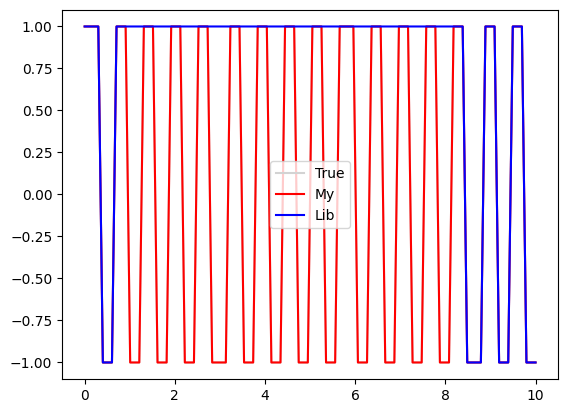

In [14]:
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.where(np.sin(X * 10).ravel() >= 0, 1, -1)

my_y =  MyAdaBoost(        n_estimators=100).fit(X, y).predict(X)
lib_y = AdaBoostClassifier(n_estimators=100).fit(X, y).predict(X)

print(f"My  acc({accuracy(y, my_y)})")
print(f"Lib acc({accuracy(y, lib_y)})")

plt.plot(X, y, label="True", color="lightgray")
plt.plot(X, my_y, label=f"My", color="red")
plt.plot(X, lib_y, label=f"Lib", color="blue")
plt.legend()

## Testing

In [15]:
df = pd.read_csv("../ml/wdbc/data.csv")

X = df.drop(["id", "diagnosis", "Unnamed: 32"], axis=1).to_numpy()
y = np.where(df["diagnosis"] == "M", 1, -1)

X_train, y_train, X_test, y_test = train_test_split(X, y)

df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,1.1760,1.2560,7.673,158.70,0.010300,0.02891,0.05198,0.02454,0.01114,0.004239,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,NaN
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0.7655,2.4630,5.203,99.04,0.005769,0.02423,0.03950,0.01678,0.01898,0.002498,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,NaN
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0.4564,1.0750,3.425,48.55,0.005903,0.03731,0.04730,0.01557,0.01318,0.003892,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,NaN
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0.7260,1.5950,5.772,86.22,0.006522,0.06158,0.07117,0.01664,0.02324,0.006185,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,NaN


In [16]:
my_score =  accuracy(y_test, MyAdaBoost(        n_estimators=100).fit(X_train, y_train).predict(X_test))
lib_score = accuracy(y_test, AdaBoostClassifier(n_estimators=100).fit(X_train, y_train).predict(X_test))

print(f"My  acc({my_score})")
print(f"Lib acc({lib_score})")

My  acc(1.0)
Lib acc(0.7803163444639719)


# Kernel Density Estimator

$$ \hat{f}(x) = \frac{1}{n h} \sum_{i=1}^{n}K(\frac{x - X_i}{h}) $$

## Implementation

In [ ]:
class MyKernelDensity(BaseEstimator):
    def __init__(self, bandwidth: float = 1, kernel: Literal["gaussian"] = "gaussian"):
        self.bandwidth = bandwidth
        self.kernel = kernel

    def fit(self, X: np.ndarray):
        self.X = np.array(X).reshape(-1, 1)
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        if self.X is None:
            raise ValueError()

        x = x.reshape(-1, 1)
        densities = np.zeros_like(x, dtype=float)
        for i, xi in enumerate(x):
            u = (xi - self.X) / self.bandwidth

            if self.kernel == "gaussian":
                k = np.exp(-0.5 * u**2) / np.sqrt(2 * np.pi)
            else:
                raise NotImplementedError()

            densities[i] = np.sum(k) / (self.X.shape[0] * self.bandwidth)

        return densities

## Comparison

In [19]:
from sklearn.neighbors import KernelDensity

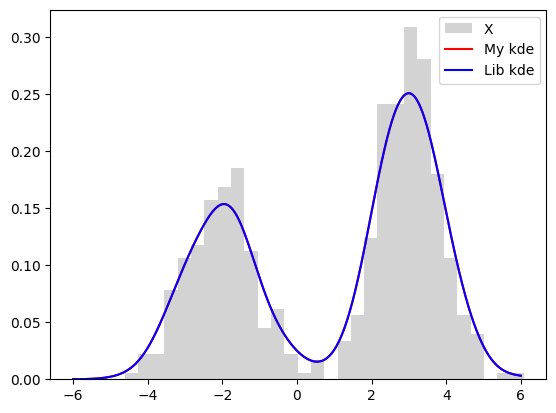

In [54]:
np.random.seed(42)
X = np.concatenate([np.random.normal(-2, 1, 200), np.random.normal(3, 0.8, 300)]).reshape(-1, 1)
x = np.linspace(-6, 6, 1000)

my_kde =  MyKernelDensity(bandwidth=0.5, kernel="gaussian").fit(X).predict(x)
lib_kde = KernelDensity(  bandwidth=0.5, kernel="gaussian").fit(X).score_samples(x.reshape(-1, 1))
lib_kde = np.exp(lib_kde)

plt.hist(X, bins=30, density=True, color="lightgray", label="X")
plt.plot(x, my_kde, color='red', label="My kde")
plt.plot(x, lib_kde, color='blue', label="Lib kde")
plt.legend()
plt.show()

## Testing

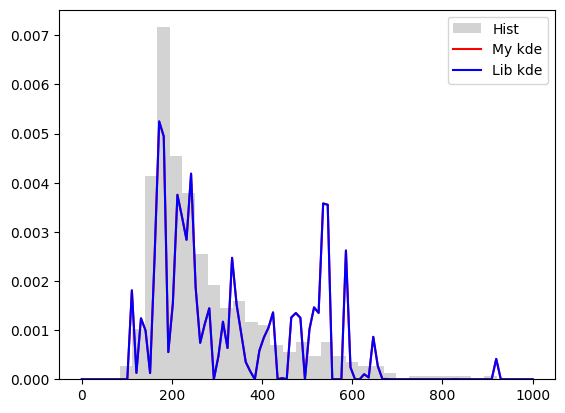

In [85]:
df = pd.read_csv("../ml/realestate.txt", sep='\t')

X = df["SalePrice"].to_numpy()
x = np.linspace(0, 1000, 100)

my_kde =  MyKernelDensity(bandwidth=0.5, kernel="gaussian").fit(X).predict(x)
lib_kde = KernelDensity(  bandwidth=0.5, kernel="gaussian").fit(X.reshape(-1, 1)).score_samples(x.reshape(-1, 1))
lib_kde = np.exp(lib_kde)

plt.hist(X, bins=30, density=True, label="Hist", color="lightgray")
plt.plot(x, my_kde, label="My kde", color="red")
plt.plot(x, lib_kde, label="Lib kde", color="blue")
plt.legend()